In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In C:\Users\Yogesh Singh\.conda\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Yogesh Singh\.conda\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Yogesh Singh\.conda\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Yogesh Singh\.conda\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\

In [2]:
train = pd.read_csv('train.csv')

In [3]:
def preprocess_data(df):
    df = missing_vals(df)
    df_new = df.drop(columns = ['Name', 'Ticket', 'Cabin', 'PassengerId'])
    df_new = pd.get_dummies(df_new, columns = ['Sex', 'Embarked'])
    return df_new

In [4]:
def missing_vals(df):
    cat_cols = df.select_dtypes(include = ['object']).columns.tolist()
    num_cols = df.select_dtypes(include = ['int64', 'float64']).columns.tolist()
    
    for column in df:
        if df[column].isna().any():
            if column in cat_cols:
                df[column] = df[column].fillna(df[column].mode()[0])
            else:
                df[column] = df[column].fillna(df[column].mean())
    return df

In [5]:
train_df = preprocess_data(train)

In [6]:
train_df

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.000000,1,0,7.2500,0,1,0,0,1
1,1,1,38.000000,1,0,71.2833,1,0,1,0,0
2,1,3,26.000000,0,0,7.9250,1,0,0,0,1
3,1,1,35.000000,1,0,53.1000,1,0,0,0,1
4,0,3,35.000000,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,13.0000,0,1,0,0,1
887,1,1,19.000000,0,0,30.0000,1,0,0,0,1
888,0,3,29.699118,1,2,23.4500,1,0,0,0,1
889,1,1,26.000000,0,0,30.0000,0,1,1,0,0


<AxesSubplot:>

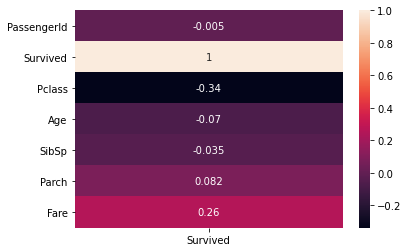

In [7]:
sns.heatmap(train.corr()[['Survived']], annot = True)

In [8]:
train_df_copy = train_df.copy()
train_df_copy.drop(columns = ['SibSp'], inplace = True)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_train, x_test, y_train, y_test = train_test_split(train_df.drop(columns = ['Survived']), train_df.Survived, test_size = 0.2, random_state = 42)

In [11]:
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score

# Instantiate TPOTClassifier
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='accuracy',
    random_state=42,
    disable_update_check=True,
    config_dict ='TPOT light'
)
tpot.fit(x_train, y_train)

# AUC score for tpot model
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(x_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')

# Print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}. {transform}')


Generation 1 - Current best internal CV score: 0.8145474244065793

Generation 2 - Current best internal CV score: 0.8145474244065793

Generation 3 - Current best internal CV score: 0.8188023244361272

Generation 4 - Current best internal CV score: 0.8215896779277061

Generation 5 - Current best internal CV score: 0.8230473751600513

Best pipeline: DecisionTreeClassifier(MultinomialNB(input_matrix, alpha=100.0, fit_prior=True), criterion=gini, max_depth=5, min_samples_leaf=15, min_samples_split=20)

AUC score: 0.8600

Best pipeline steps:
1. StackingEstimator(estimator=MultinomialNB(alpha=100.0, class_prior=None,
                                          fit_prior=True))
2. DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=20,
                       mi

In [12]:
tpot.score(x_test, y_test)

0.8100558659217877

In [ ]:
# tpot.export('tpotlight_titanic.py')